#### Notes on current version:
**To Try**:
- Cayley parameterization](https://planetmath.org/cayleysparameterizationoforthogonalmatrices) of $SU_d$ (since this is really all we need)...*will it be more stable than Lie's parameterization?* Note: it is a homeomorphism so this is great for UAP!
- SVD approach to pre-trainining 
  - (here for procrustes problem)[https://en.wikipedia.org/wiki/Orthogonal_Procrustes_problem]
  - [here for complexity](https://mathoverflow.net/questions/161252/what-is-the-time-complexity-of-truncated-svd)
  
- Get the base version working:

- Add the tall version...

# NEU (Reconfigurations Map and Related Functions)

### Basic Algorithm (NEU-OLS)

1. Perform Basic Algorithm (in this case OLS)
2. Map predictions to their graph; ie $x\mapsto (x,\hat{f}_{OLS}(x))$ where $\hat{f}_{OLS}$ is the least-squares regression function.

## Initializations:

In [1]:
# Deep Learning & ML
import tensorflow as tf
import tensorflow_probability as tfp
import keras as K
import keras.backend as Kb
from keras.layers import *

from keras.models import Model
from keras.models import Sequential
from keras import layers
from keras import utils as np_utils
from scipy import linalg as scila

from tensorflow.keras.initializers import RandomUniform
from tensorflow.keras.constraints import NonNeg



# Linear Regression
from sklearn.linear_model import LinearRegression

# General
import numpy as np
import time

# Alerts
import os as beepsnd

# Others
import math

# Visualization
from matplotlib.pyplot import figure

# General Outputs
print('TensorFlow:', tf.__version__)

Using TensorFlow backend.


TensorFlow: 2.1.0


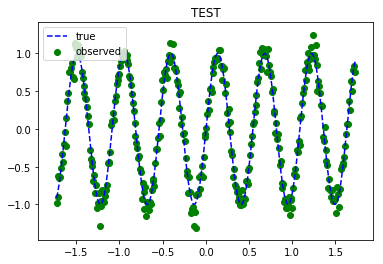

In [2]:
N_Reconfigurations = 20
d = 1 # Dimension of X
D = 1 # Dimension of Y


# Data Meta-Parameters
noise_level = 0.1
uncertainty_level= 0.5

# Training meta-parameters
Pre_Epochs = 5
Full_Epochs = 10

# Depth & Height of first Reconfiguration
Initial_Depth = 1
Initial_Height = 5
# Depth & Height Per Reconfiguration
Depth_per_reconfig = 1
Height_per_reconfig = 5

# Number of Datapoints
N_data = 10**2
# Unknown Function
def unknown_f(x):
    return np.sin(2*x) #+ (x % 2)

# Generate Data
%run Data_Generator.ipynb

#### Prepare data for NEU

In [3]:
# Reshape Data Into Compatible Shape
data_x = np.array(data_x).reshape(-1,d)
data_y = np.array(data_y)
# Perform OLS Regression
linear_model = LinearRegression()
reg = linear_model.fit(data_x, data_y)
model_pred_y = linear_model.predict(data_x)
# Map to Graph
data_NEU = np.concatenate((data_x,model_pred_y.reshape(-1,D)),1)
NEU_targets_full  = np.concatenate((data_x,data_y.reshape(-1,D)),1)
NEU_targets  = data_y.reshape(-1,D)

### Helper Function(s)

In [4]:
def above_percentile(x, p): #assuming the input is flattened: (n,)

    samples = Kb.cast(Kb.shape(x)[0], Kb.floatx()) #batch size
    p =  (100. - p)/100.  #100% will return 0 elements, 0% will return all elements

    #selected samples
    values, indices = tf.math.top_k(x, samples)

    return values

# def Robust_MSE(p):
#     def loss(y_true, y_predicted):
#         ses = Kb.pow(y_true-y_predicted,2)
#         above = above_percentile(Kb.flatten(ses), p)
#         return Kb.mean(above)
#     return loss
def Robust_MSE(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)

    y_true.shape = (y_true.shape[0], 1)
    y_pred.shape = (y_pred.shape[0], 1)

    # Compute Exponential Utility
    loss_out = np.abs((y_true - y_pred))
    loss_out = np.math.exp(-p*loss_out)
    loss_out = np.mean(loss_out)
    return loss_out

## $\operatorname{SAff}_{d}(\mathbb{R}) \cong \mathbb{R}^d \rtimes \operatorname{SL}_{d}(\mathbb{R})$  Layers

Note: $A \in \operatorname{SL}_d(\mathbb{R})$ if and only if $A=\frac1{\sqrt[d]{\det(\exp(X))}} \exp(X)$ for some $d\times d$ matrix $X$.  

*Why?*... We use the fact that $\det(k A) = k^d \det(A)$ for any $k \in \mathbb{R}$ and any $d\times d$ matrix A.

In [5]:
class Special_Affine_Layer(tf.keras.layers.Layer):
    
    def __init__(self, units=16, input_dim=32):
        super(Special_Affine_Layer, self).__init__()
        self.units = units
    
    def build(self, input_shape):
        #------------------------------------------------------------------------------------#
        # Tangential Parameters
        #------------------------------------------------------------------------------------#
        # For Numerical Stability (problems with Tensorflow's Exp rounding)
        self.Id = self.add_weight(name='Identity_Matrix',
                                   shape=(input_shape[-1],input_shape[-1]),
                                   initializer='identity',
                                   trainable=False)
        # Element of gld
        self.glw = self.add_weight(name='Tangential_Weights',
                                   shape=(input_shape[-1],input_shape[-1]),
                                   initializer='GlorotUniform',
                                   trainable=True)
        
        #------------------------------------------------------------------------------------#
        # Euclidean Parameters
        #------------------------------------------------------------------------------------#
        self.b = self.add_weight(name='location_parameter',
                                 shape=(self.units,),
                                 initializer='random_normal',
                                 trainable=False)
        # Wrap things up!
        super().build(input_shape)
        
    def call(self, input):
        # Build Tangential Feed-Forward Network (Bonus)
        #-----------------------------------------------#
        GLN = tf.linalg.expm(self.glw)
        GLN_det = tf.linalg.det(GLN)
        GLN_det = tf.pow(tf.abs(GLN_det),(1/(d+D)))
        SLN = tf.math.divide(GLN,GLN_det)
        
        # Exponentiation and Action
        #----------------------------#
        x_out = input
        x_out = tf.linalg.matvec(SLN,x_out)
        x_out = x_out + self.b
        
        # Return Output
        return x_out

## $\operatorname{E}_{d}(\mathbb{R}) \cong \mathbb{R}^d \rtimes \operatorname{O}_{d}(\mathbb{R})$  Layers

This is the group of all isometries of $\mathbb{R}^d$.

In [6]:
class Euclidean_Layer(tf.keras.layers.Layer):
    
    def __init__(self, units=16, input_dim=32):
        super(Euclidean_Layer, self).__init__()
        self.units = units
    
    def build(self, input_shape):
        #------------------------------------------------------------------------------------#
        # Tangential Parameters
        #------------------------------------------------------------------------------------#
        # For Numerical Stability (problems with Tensorflow's Exp rounding)
        self.Id = self.add_weight(name='Identity_Matrix',
                                   shape=(input_shape[-1],input_shape[-1]),
                                   initializer='identity',
                                   trainable=False)
        # Element of gld
        self.glw = self.add_weight(name='Tangential_Weights',
                                   shape=(input_shape[-1],input_shape[-1]),
                                   initializer='GlorotUniform',
                                   trainable=True)
        
        #------------------------------------------------------------------------------------#
        # Euclidean Parameters
        #------------------------------------------------------------------------------------#
        self.b = self.add_weight(name='location_parameter',
                                 shape=(self.units,),
                                 initializer='random_normal',
                                 trainable=False)
        # Wrap things up!
        super().build(input_shape)
        
    def call(self, input):
        # Build Tangential Feed-Forward Network (Bonus)
        #-----------------------------------------------#
        On = tf.linalg.matmul((self.Id + self.glw),tf.linalg.inv(self.Id - self.glw))
        
        # Exponentiation and Action
        #----------------------------#
        x_out = input
        x_out = tf.linalg.matvec(On,x_out)
        x_out = x_out + self.b
        
        # Return Output
        return x_out

## Deep GLd Layer:
$$
\begin{aligned}
\operatorname{Deep-GL}_d(x) \triangleq& f^{Depth}\circ \dots f^1(x)\\
f^i(x)\triangleq &\exp(A_2) \operatorname{Leaky-ReLU}\left(
\exp(A_1)x + b_1
\right)+ b_2
\end{aligned}
$$
where $A_i$ are $d\times d$ matrices and $b_i \in \mathbb{R}^d$. 

In [7]:
class Deep_GLd_Layer(tf.keras.layers.Layer):
    
    def __init__(self, units=16, input_dim=32):
        super(Deep_GLd_Layer, self).__init__()
        self.units = units
    
    def build(self, input_shape):
        #------------------------------------------------------------------------------------#
        # Tangential Parameters
        #------------------------------------------------------------------------------------#
        # For Numerical Stability (problems with Tensorflow's Exp rounding)
#         self.Id = self.add_weight(name='Identity_Matrix',
#                                    shape=(input_shape[-1],input_shape[-1]),
#                                    initializer='identity',
#                                    trainable=False)
#         self.num_stab_param = self.add_weight(name='matrix_exponential_stabilizer',
#                                               shape=[1],
#                                               initializer=RandomUniform(minval=0.0, maxval=0.01),
#                                               trainable=True,
#                                               constraint=tf.keras.constraints.NonNeg())
#         Element of gl_d
        self.glw = self.add_weight(name='Tangential_Weights',
                                   shape=(input_shape[-1],input_shape[-1]),
                                   initializer='GlorotUniform',
                                   trainable=True)
        self.glw2 = self.add_weight(name='Tangential_Weights2',
                                       shape=(input_shape[-1],input_shape[-1]),
                                       initializer='GlorotUniform',
                                       trainable=True)
        
        #------------------------------------------------------------------------------------#
        # Euclidean Parameters
        #------------------------------------------------------------------------------------#
        self.b = self.add_weight(name='location_parameter',
                                 shape=(self.units,),
                                 initializer='random_normal',
                                 trainable=False)
        self.b2 = self.add_weight(name='location_parameter2',
                                 shape=(self.units,),
                                 initializer='random_normal',
                                 trainable=False)
        # Wrap things up!
        super().build(input_shape)
        
    def call(self, input):
        # Build Tangential Feed-Forward Network (Bonus)
        #-----------------------------------------------#
        GLN = tf.linalg.expm(self.glw)
        GLN2 = tf.linalg.expm(self.glw2)
        
        # Exponentiation and Action
        #----------------------------#
        x_out = input

        x_out = tf.linalg.matvec(GLN,x_out)
        x_out = x_out + self.b
        x_out = tf.nn.leaky_relu(x_out)
        x_out = tf.linalg.matvec(GLN2,x_out)
        x_out = x_out + self.b2
        
        # Return Output
        return x_out

### Build Reconfiguration Unit
*Lie Version:* $$
x \mapsto \exp\left(
%\psi(a\|x\|+b)
\operatorname{Skew}_d\left(
    F(\|x\|)
\right)
\right) x.
$$

*Cayley version:*
$$
\begin{aligned}
\operatorname{Cayley}(A(x)):\,x \mapsto & \left[(I_d + A(x))(I_d- A(x))^{-1}\right]x
\\
A(x)\triangleq &%\psi(a\|x\|+b)
\operatorname{Skew}_d\left(
    F(\|x\|)\right).
\end{aligned}
$$

Note that the inverse of the Cayley transform of $A(x)$ is:
$$
\begin{aligned}
\operatorname{Cayley}^{-1}(A(x)):\,x \mapsto & \left[(I_d - A(x))(I_d+ A(x))^{-1}\right]x
.
\end{aligned}
$$

In [ ]:
class Reconfiguration_unit(tf.keras.layers.Layer):
    
    def __init__(self, units=16, input_dim=32):
        super(Reconfiguration_unit, self).__init__()
        self.units = units
    
    def build(self, input_shape):
        #------------------------------------------------------------------------------------#
        # Center
        #------------------------------------------------------------------------------------#
        self.location = self.add_weight(name='location',
                                    shape=(input_shape[-1],),
                                    initializer='random_normal',
                                    trainable=True)
        
        
        #------------------------------------------------------------------------------------#
        #====================================================================================#
        #------------------------------------------------------------------------------------#
        #====================================================================================#
        #                                  Decay Rates                                       #
        #====================================================================================#
        #------------------------------------------------------------------------------------#
        #====================================================================================#
        #------------------------------------------------------------------------------------#
        
        
        #------------------------------------------------------------------------------------#
        # Bump Function
        #------------------------------------------------------------------------------------#
        self.sigma = self.add_weight(name='bump_threshfold',
                                        shape=[1],
                                        initializer=RandomUniform(minval=.5, maxval=1),
                                        trainable=True,
                                        constraint=tf.keras.constraints.NonNeg())
        self.a = self.add_weight(name='bump_scale',
                                        shape=[1],
                                        initializer='ones',
                                        trainable=True)
        self.b = self.add_weight(name='bump_location',
                                        shape=[1],
                                        initializer='zeros',
                                        trainable=True)
        
        #------------------------------------------------------------------------------------#
        # Exponential Decay
        #------------------------------------------------------------------------------------#
        self.exponential_decay = self.add_weight(name='exponential_decay_rate',
                                                 shape=[1],
                                                 initializer=RandomUniform(minval=.5, maxval=1),
                                                 trainable=True,
                                                 constraint=tf.keras.constraints.NonNeg())
        
        #------------------------------------------------------------------------------------#
        # Mixture
        #------------------------------------------------------------------------------------#
        self.m_w1 = self.add_weight(name='no_decay',
                                         shape=[1],
                                         initializer=RandomUniform(minval=.5, maxval=1),
                                         trainable=True,
                                         constraint=tf.keras.constraints.NonNeg())
        self.m_w2 = self.add_weight(name='weight_exponential',
                                         shape=[1],
                                         initializer=RandomUniform(minval=.5, maxval=1),
                                         trainable=True,
                                         constraint=tf.keras.constraints.NonNeg())
        self.m_w3 = self.add_weight(name='bump',
                                     shape=[1],
                                     initializer=RandomUniform(minval=.5, maxval=1),
                                     trainable=True,
                                     constraint=tf.keras.constraints.NonNeg())
        
        #------------------------------------------------------------------------------------#
        # Tangential Map
        #------------------------------------------------------------------------------------#
        self.Id = self.add_weight(name='Identity_Matrix',
                                   shape=(input_shape[-1],input_shape[-1]),
                                   initializer='identity',
                                   trainable=False)
        self.Tw1 = self.add_weight(name='Tangential_Weights_1 ',
                                   shape=(self.units,((d+D)**2)),
                                   initializer='GlorotUniform',
                                   trainable=True)        
        self.Tw2 = self.add_weight(name='Tangential_Weights_2 ',
                                   shape=(((d+D)**2),self.units),
                                   initializer='GlorotUniform',
                                   trainable=True)
        self.Tb1 = self.add_weight(name='Tangential_basies_1',
                                   shape=(((input_shape[-1])**2),1),
                                   initializer='GlorotUniform',
                                   trainable=True)
        self.Tb2 = self.add_weight(name='Tangential_basies_1',
                                   shape=((d+D),(d+D)),
                                   initializer='GlorotUniform',
                                   trainable=True)
        
        
        # Stability Parameter(s)
#         self.num_stab_param = self.add_weight(name='matrix_exponential_stabilizer',shape=[1],initializer=RandomUniform(minval=0.0, maxval=0.01),trainable=True,constraint=tf.keras.constraints.NonNeg())
        
        # Wrap things up!
        super().build(input_shape)

    def bump_function(self, x):
        return tf.math.exp(-self.sigma / (self.sigma - x))

        
    def call(self, input):
        #------------------------------------------------------------------------------------#
        # Initializations
        #------------------------------------------------------------------------------------#
        norm_inputs = tf.norm(input) #WLOG if norm is squared!
        
        #------------------------------------------------------------------------------------#
        # Decay Rate Functions
        #------------------------------------------------------------------------------------#
        # Bump Function (Local Behaviour)
        bump_input = self.a *norm_inputs + self.b
        greater = tf.math.greater(bump_input, -self.sigma)
        less = tf.math.less(bump_input, self.sigma)
        condition = tf.logical_and(greater, less)

        bump_decay = tf.where(
            condition, 
            self.bump_function(bump_input),
            0.0)
        # Exponential Decay
        exp_decay = tf.math.exp(-self.exponential_decay)
        
        
        
        
        #------------------------------------------------------------------------------------#
        # Tangential Map
        #------------------------------------------------------------------------------------#
        # Build Radial, Tangent-Space Valued Function, i.e.: C(R^d,so_d) st. f(x)=f(y) if |x|=|y|
        
        
        # Build Tangential Feed-Forward Network (Bonus)
        #-----------------------------------------------#
        tangential_ffNN = norm_inputs*self.Id
        tangential_ffNN = tf.reshape(tangential_ffNN,[((d+D)**2),1])
        tangential_ffNN = tangential_ffNN + self.Tb1
        
        tangential_ffNN = tf.linalg.matmul(self.Tw1,tangential_ffNN)         
        tangential_ffNN = tf.nn.relu(tangential_ffNN)
        tangential_ffNN = tf.linalg.matmul(self.Tw2,tangential_ffNN)
        tangential_ffNN = tf.reshape(tangential_ffNN,[(d+D),(d+D)])
        tangential_ffNN = tangential_ffNN + self.Tb2
    
        # Map to Rotation-Matrix-Valued Function #
        #----------------------------------------#
        tangential_ffNN = (tf.transpose(tangential_ffNN) - tangential_ffNN) 
        tangential_ffNN = (self.m_w1*1 + self.m_w2*exp_decay +  self.m_w3*bump_decay)*tangential_ffNN
        
        tangential_ffNN = tangential_ffNN #+ self.num_stab_param*tf.linalg.diag(tf.ones(d+D))
            
        # Cayley Transformation (Stable):
        tangential_ffNN = tf.linalg.matmul((self.Id + tangential_ffNN),tf.linalg.inv(self.Id - tangential_ffNN)) # Lie Parameterization (Numerically Unstable):  #tangential_ffNN = tf.linalg.expm(tangential_ffNN)
        
        # Exponentiation and Action
        #----------------------------#
        x_out = tf.linalg.matvec(tangential_ffNN,input) + self.location
#         x_out = tf.linalg.matvec(tangential_ffNN,input)
        
        # Return Output
        return x_out

# Build

In [ ]:
# define and fit the base model
def get_base_model(trainx, trainy, Pre_Epochs_in, depth, height):
    # Define Model
    #----------------#
    # Initialize
    input_layer = tf.keras.Input(shape=[d+D])
    
    # Apply Reconfiguration Unit
    output_layer  = Reconfiguration_unit(height)(input_layer)
    
    if depth > 0:
        output_layer = Euclidean_Layer(d+D)(output_layer)
        output_layer  = Reconfiguration_unit(height)(output_layer)
        output_layer = Euclidean_Layer(d+D)(output_layer)
    
    # Output
#     output_layer = projection_layer(output_layer)
    reconfiguration_basic = tf.keras.Model(inputs=[input_layer], outputs=[output_layer])
    
    # Compile Model
    #----------------#
    # Define Optimizer
    optimizer_on = tf.keras.optimizers.SGD(learning_rate=10**(-2), momentum=0.01, nesterov=True)
    # Compile
    reconfiguration_basic.compile(loss = 'mae',
                    optimizer = optimizer_on,
                    metrics = ['mse'])
    
    # Fit Model
    #----------------#
    reconfiguration_basic.fit(trainx, trainy, epochs=Pre_Epochs_in, verbose=0)
        
    # Return Output
    return reconfiguration_basic

In [ ]:
# define and fit the base model
def get_base_model_deep_GLd(trainx, trainy, Full_Epochs_in, depth):
    # Define Model
    #----------------#
    # Initialize
    input_layer = tf.keras.Input(shape=[d+D])
    
    # Apply Reconfiguration Unit
    output_layer = Deep_GLd_Layer(d+D)(input_layer)
    
    if depth > 0:
        output_layer = Deep_GLd_Layer(d+D)(output_layer)
    
    # Output
#     output_layer = projection_layer(output_layer)
    reconfiguration_basic = tf.keras.Model(inputs=[input_layer], outputs=[output_layer])
    
    # Compile Model
    #----------------#
    # Define Optimizer
    optimizer_on = tf.keras.optimizers.SGD(learning_rate=10**(-2), momentum=0.01, nesterov=True)
    # Compile
    reconfiguration_basic.compile(loss = 'mae',
                    optimizer = optimizer_on,
                    metrics = ['mse'])
    
    # Fit Model
    #----------------#
    reconfiguration_basic.fit(trainx, trainy, epochs=Full_Epochs_in, verbose=10)
        
    # Return Output
    return reconfiguration_basic

#### Greedy Initialization of Subsequent Units
Build reconfiguration and pre-train using greedy approach.

In [ ]:
def add_reconfiguration_unit_greedily(model, trainx, trainy, Pre_Epochs_in, depth, height):

    # Dissasemble Network
    layers = [l for l in model.layers]

    # Define new reconfiguration unit to be added
    output_layer_new  = Reconfiguration_unit(d+D)(layers[len(layers)-2].output)

    if depth > 0:
        output_layer_new = Euclidean_Layer(d+D)(output_layer_new)
        output_layer_new  = Reconfiguration_unit(height)(output_layer_new)
        output_layer_new = Euclidean_Layer(d+D)(output_layer_new)

    for i in range(len(layers)):
        layers[i].trainable = False


    # build model
    new_model = tf.keras.Model(inputs=[layers[0].input], outputs=output_layer_new)
    #new_model.summary()


    # Compile new Model
    #-------------------#
    # Define Optimizer
    optimizer_on = tf.keras.optimizers.SGD(learning_rate=10**(-2), momentum=0.01, nesterov=True)
    # Compile Model
    new_model.compile(loss = 'mae',
                    optimizer = optimizer_on,
                    metrics = ['mse'])

    # Fit Model
    #----------------#
    new_model.fit(trainx, trainy, epochs=Pre_Epochs_in, verbose=0)

    # Return Output
    return new_model

#### Train and Compile (entire) reconfiguration using greedy-initializations past from previous helper functions.
Train reconfiguration together (initialized by greedy) layer-wise initializations.

In [ ]:
def build_reconfiguration(model_greedy_initialized, trainx, trainy, Full_Epochs_in, height):

    # Dissasemble Network
    layers = [l for l in model_greedy_initialized.layers]

    # Define new reconfiguration unit to be added
    output_layer_new  = Euclidean_Layer(d+D)(layers[len(layers)-2].output)
    output_layer_new  = Reconfiguration_unit(height)(output_layer_new)
    output_layer_new  = Euclidean_Layer(d+D)(output_layer_new)

    # Output Layer
#     output_layer_new = projection_layer(output_layer_new)

    for i in range(len(layers)):
        layers[i].trainable = True


    # build model
    reconfiguration = tf.keras.Model(inputs=[layers[0].input], outputs=output_layer_new)
    #new_model.summary()



    # Compile new Model
    #-------------------#
    # Define Optimizer
    optimizer_on = tf.keras.optimizers.SGD(learning_rate=10**(-5), momentum=0.01, nesterov=True)

    # Compile Model
    reconfiguration.compile(loss = 'mae',
                    optimizer = optimizer_on,
                    metrics = ['mse'])

    # Fit Model
    #----------------#
    reconfiguration.fit(trainx, trainy, epochs=Full_Epochs_in, verbose=1)

    # Return Output
    return reconfiguration

# Train NEU-OLS
- Get Base Model,
- Greedy Layer-Wise Initialization,
- SGD on entire structure.

In [ ]:
# Base Model
model = get_base_model(data_NEU,NEU_targets,10,Initial_Depth,Initial_Height)

In [ ]:
# Greedy Initialization
NEU_OLS_Greedy_init = model
for i in range(N_Reconfigurations):
    # Update User on Status of Initialization
    print(((i+1)/N_Reconfigurations))
    
    # Update Model
    NEU_OLS_Greedy_init_temp = add_reconfiguration_unit_greedily(NEU_OLS_Greedy_init,
                                                                 data_NEU,
                                                                 NEU_targets_full,
                                                                 Pre_Epochs,
                                                                 Depth_per_reconfig,
                                                                 Height_per_reconfig)
    
    # Check for Blowup
    if math.isnan(np.mean(NEU_OLS_Greedy_init.predict(data_NEU))):
        NEU_OLS_Greedy_init = NEU_OLS_Greedy_init
        break
    else: #Update Model if not explosion
        NEU_OLS_Greedy_init = NEU_OLS_Greedy_init_temp
    
    print(np.mean(np.abs((NEU_OLS_Greedy_init.predict(data_NEU) - NEU_targets_full)**2)))
    

Next we train NEU-OLS, by unfreezing the greedily initialized layers and using SGD on the whole structure.

In [ ]:
NEU_OLS = build_reconfiguration(model_greedy_initialized=NEU_OLS_Greedy_init, 
                                trainx = data_NEU, 
                                trainy = NEU_targets, 
                                Full_Epochs_in = Full_Epochs, 
                                height = Height_per_reconfig)

In [ ]:
Deep_GLd = get_base_model_deep_GLd(data_NEU,
                                   NEU_targets,
                                   Full_Epochs_in = Full_Epochs, 
                                   depth = (N_Reconfigurations*Initial_Depth))

## Make Predictions

In [ ]:
# # Predictions (for comparison: TEMP)
NEU_OLS_single_unit_prediction = model.predict(data_NEU)
NEU_OLS_greedy_initializations = NEU_OLS_Greedy_init.predict(data_NEU)
NEU_OLS_prediction = NEU_OLS.predict(data_NEU)
Deep_GLd_prediction = Deep_GLd.predict(data_NEU)

# Visualize Predictions

In [ ]:
# Initialization
visualization_grid = np.random.uniform(-10,10,[1000,2])
figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')

# Plot Data
plt.scatter(visualization_grid[:,0],visualization_grid[:,1],color='red',marker = '.')
# Transform Data
NEU_OLS_prediction_visualization_init = model.predict(visualization_grid)
NEU_OLS_prediction_visualization_Greedy = NEU_OLS_Greedy_init.predict(visualization_grid)
NEU_OLS_prediction_visualization = NEU_OLS.predict(visualization_grid)
Deep_GLd_prediction_visualization = Deep_GLd.predict(visualization_grid)

# Plot Transformed Data
plt.scatter(NEU_OLS_prediction_visualization_init[:,0],NEU_OLS_prediction_visualization_init[:,1],color='b',label='Init',marker = '.')
plt.scatter(NEU_OLS_prediction_visualization_Greedy[:,0],NEU_OLS_prediction_visualization_Greedy[:,1],color='g',label='NEU_Greedy',marker = '.')
plt.scatter(NEU_OLS_prediction_visualization[:,0],NEU_OLS_prediction_visualization[:,1],color='purple',label='NEU',marker = '.')
plt.scatter(Deep_GLd_prediction_visualization[:,0],Deep_GLd_prediction_visualization[:,1],color='black',label='NEU',marker = '.')

Detailed Visualization... evolution of NEU through training

In [ ]:
# Adjust Figure Details
plt.figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')

# Data Plot
plt.plot(data_x,data_y,color='k',label='true',linestyle='--')

# Plot Models
plt.plot(data_x,model_pred_y,color='r',label='OLS')
plt.plot(data_x,NEU_OLS_single_unit_prediction[:,1],color='b',label='NEU_Unit')
plt.plot(data_x,NEU_OLS_greedy_initializations[:,1],color='g',label='NEU_Greedy_Init')
plt.plot(data_x,NEU_OLS_prediction[:,1],color='purple',label='NEU-OLS')
plt.plot(data_x,Deep_GLd_prediction[:,1],color='black',label='Deep_GLd')

Succinct graph (results only)

In [ ]:
# Adjust Figure Details
plt.figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')

# Data Plot
plt.plot(data_x,true_y,color='k',label='true',linestyle='--')

# Plot Models
plt.plot(data_x,model_pred_y,color='r',label='OLS')
plt.plot(data_x,NEU_OLS_prediction[:,1],color='purple',label='NEU-OLS')
plt.plot(data_x,Deep_GLd_prediction[:,1],color='black',label='Deep_GLd')

 ---

#### The END